In [5]:
dataset <- "SIRToscana"
state <- "Toscana"


In [6]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(DBI, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source("src/database/startup.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/database/query/pairing.R")
source("src/database/query/analysis.R")
source("src/pairing/displaying.R")
source("src/database/plot.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


In [7]:
query <- glue::glue_sql(
    "
        WITH state_station AS (
            SELECT DISTINCT on (s.id)
                s.dataset,
                s.id,
                s.geom,
                s.geog
            FROM station_geo s
            JOIN boundary b
            ON ST_Within(s.geom, b.geom)
            WHERE b.name = {state} OR s.dataset = {dataset}
        )
        SELECT
            sx.dataset AS dataset_x,
            sx.id AS id_x,
            sy.dataset AS dataset_y,
            sy.id AS id_y,
            ST_Distance(sx.geog, sy.geog) AS distance
        FROM state_station sx
        JOIN state_station sy
        ON ST_DWithin(sx.geog, sy.geog, 6000)
        WHERE sx.id != sy.id
    ",
    .con = conns$stations
)
close_stations <- dbGetQuery(conns$stations, query)
dbWriteTable(
    conns$data,
    "close_stations_tmp",
    close_stations,
    overwrite = TRUE
)


In [8]:
dbExecute(conns$data, "SET memory_limit = '12.5GB'")


[1] 0

In [9]:
metadata <- tbl(conns$data, "stations_tmp")
dbExecute(conns$data, "DROP TABLE IF EXISTS data_tmp")
data <- valid_data(conns$data) |>
    semi_join(metadata, join_by(station_id == id)) |>
    compute(temporary = FALSE, name = "data_tmp")
matches <- data |>
    valid_series() |>
    collect() |>
    series_matches(tbl(conns$data, "close_stations_tmp") |> collect(), asymmetric = TRUE, cmp = \(x, y) x > y) |>
    select(id_x, id_y, variable, distance)


[1] 0

In [10]:
analysis <- series_matches_analysis(matches, data, metadata)


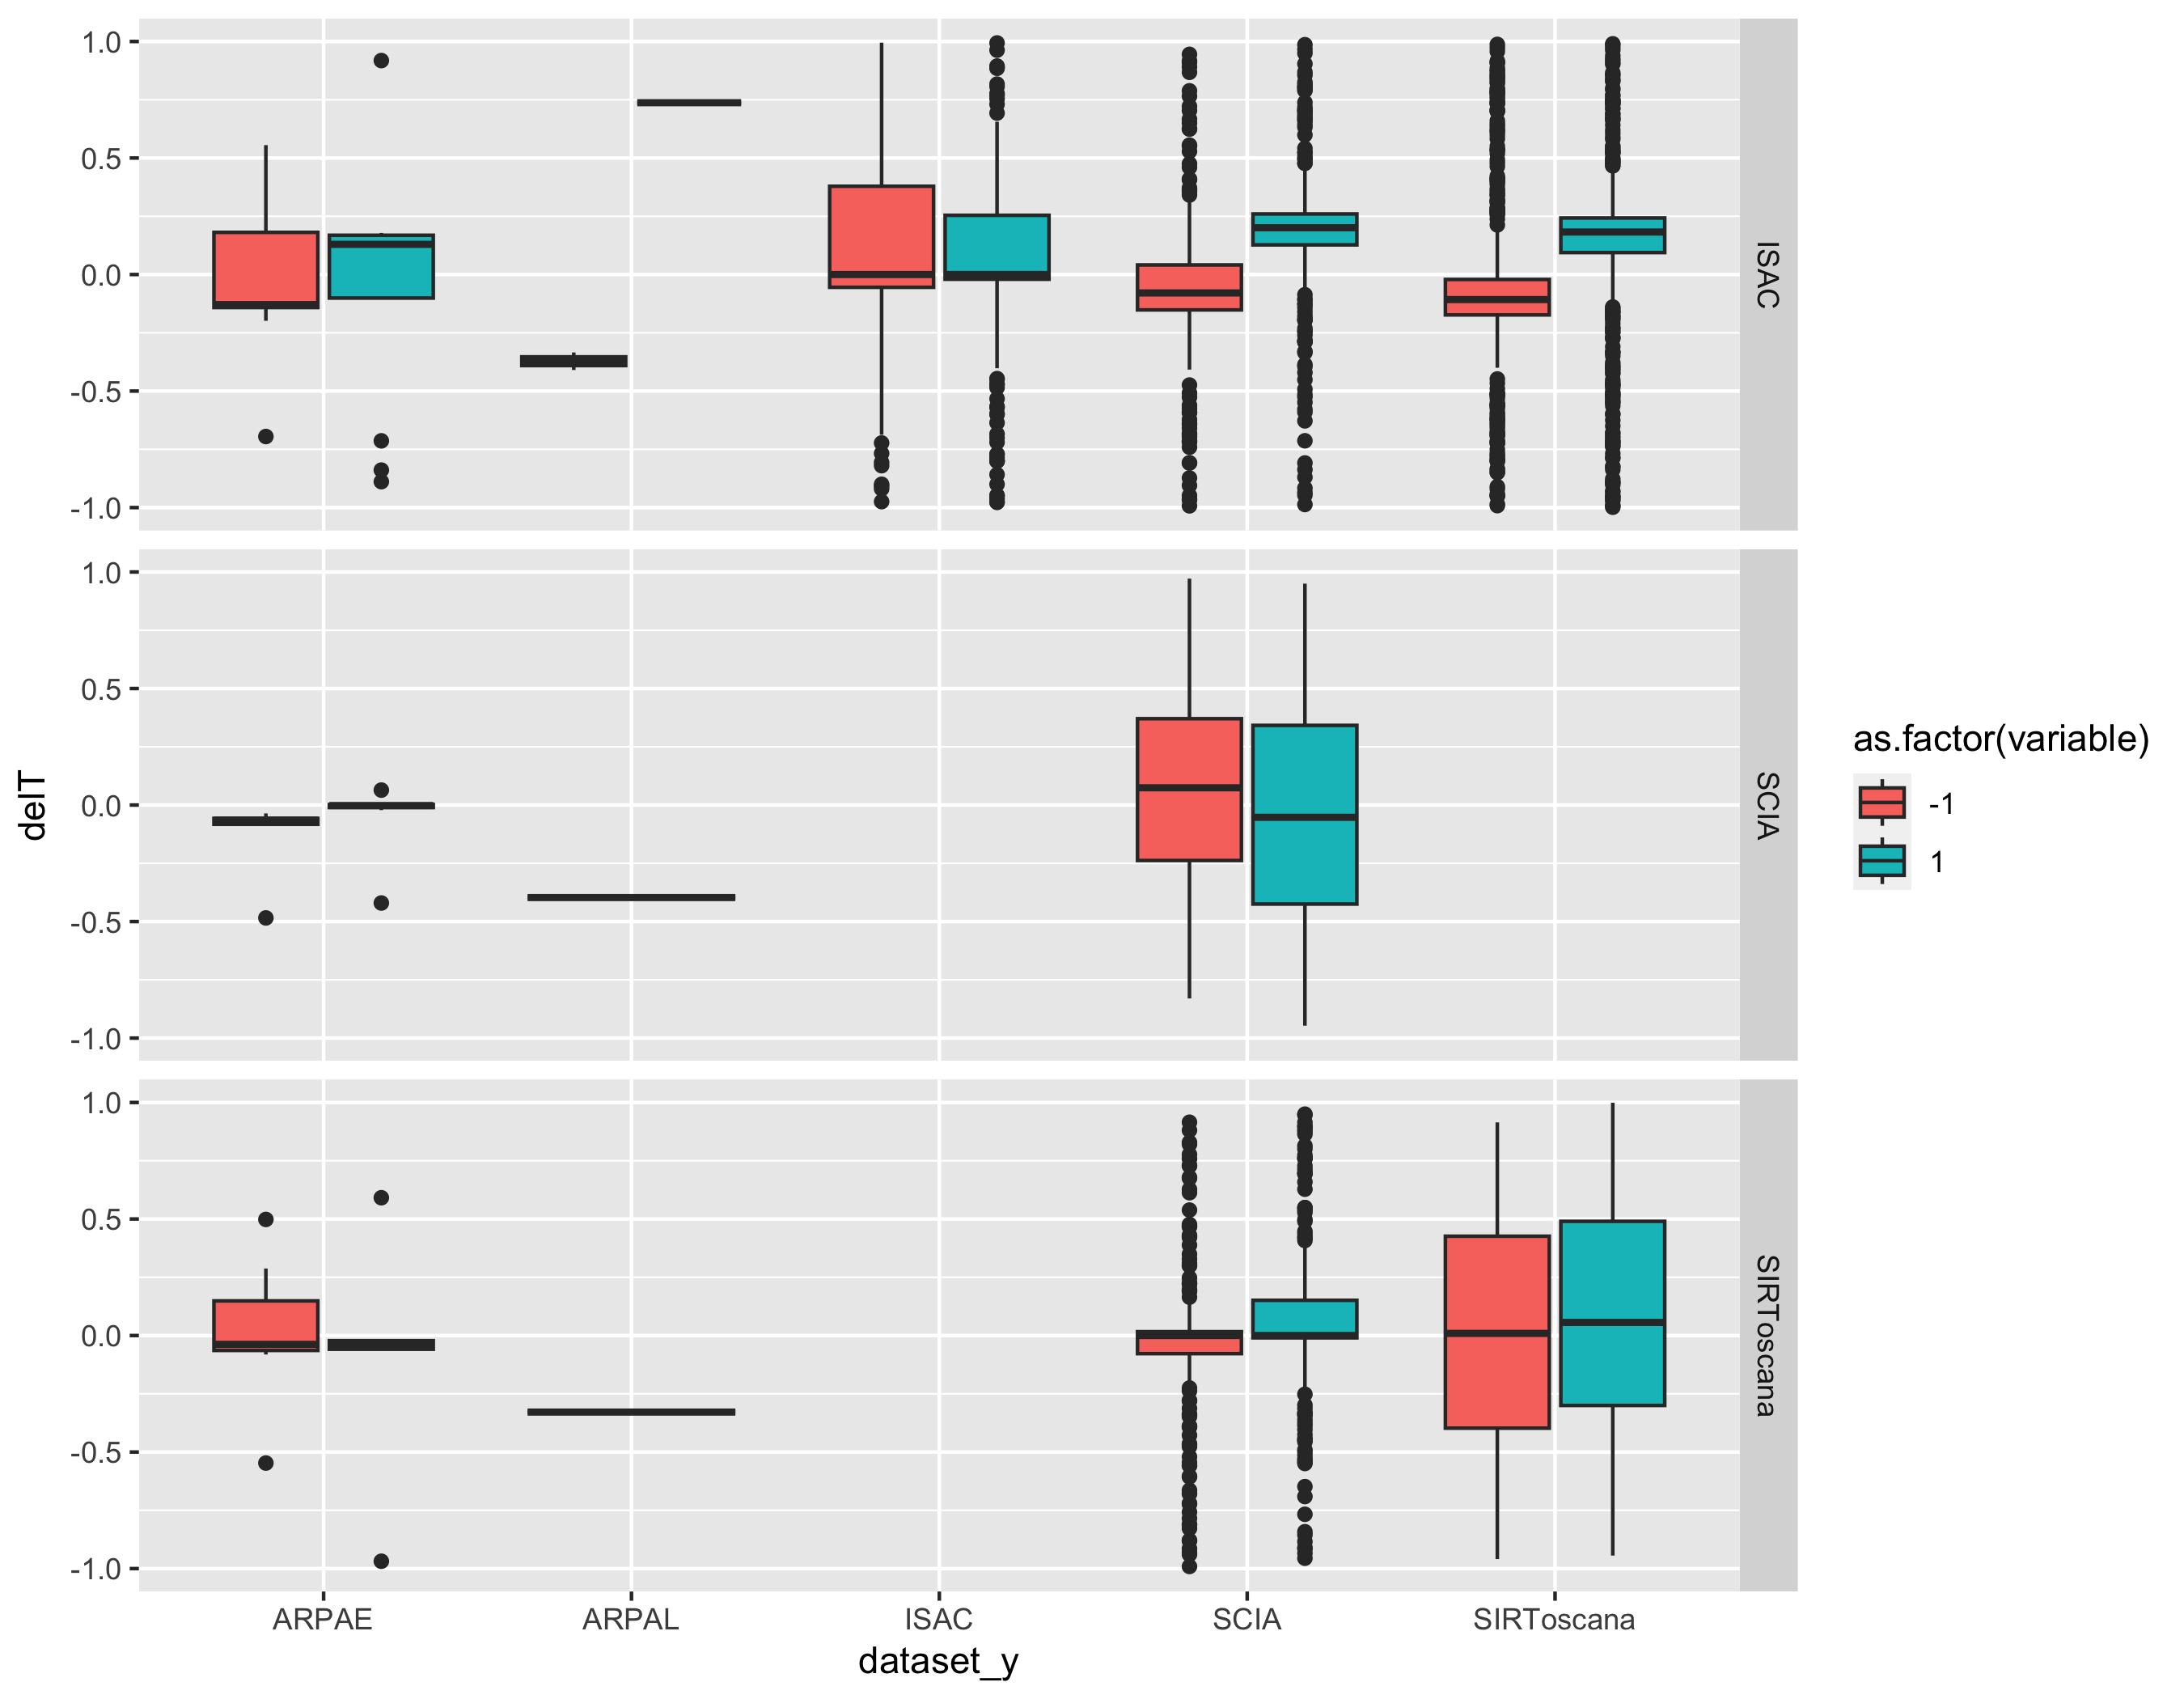

In [11]:
library(ggplot2)
ggplot(data = analysis |> filter(abs(delT) < 1)) + geom_boxplot(aes(x = dataset_y, y = delT, fill = as.factor(variable))) + facet_grid(dataset_x ~ .)

SCIA e SIRToscana registrano le stesse variabili, mentre quelle di ISAC sono sistematicamente meno estreme: probabilmente in Toscana ISAC prende gli estremi delle medie orarie

In [12]:
write_xslx_analysis(analysis, file.path("notebooks", "integrazioni_regionali", "toscana", "analysis.xlsx"))


ATTENZIONE: diverse stazioni di ISAC sembrano etichettate in maniera scorretta. Droppare ciò che resta.

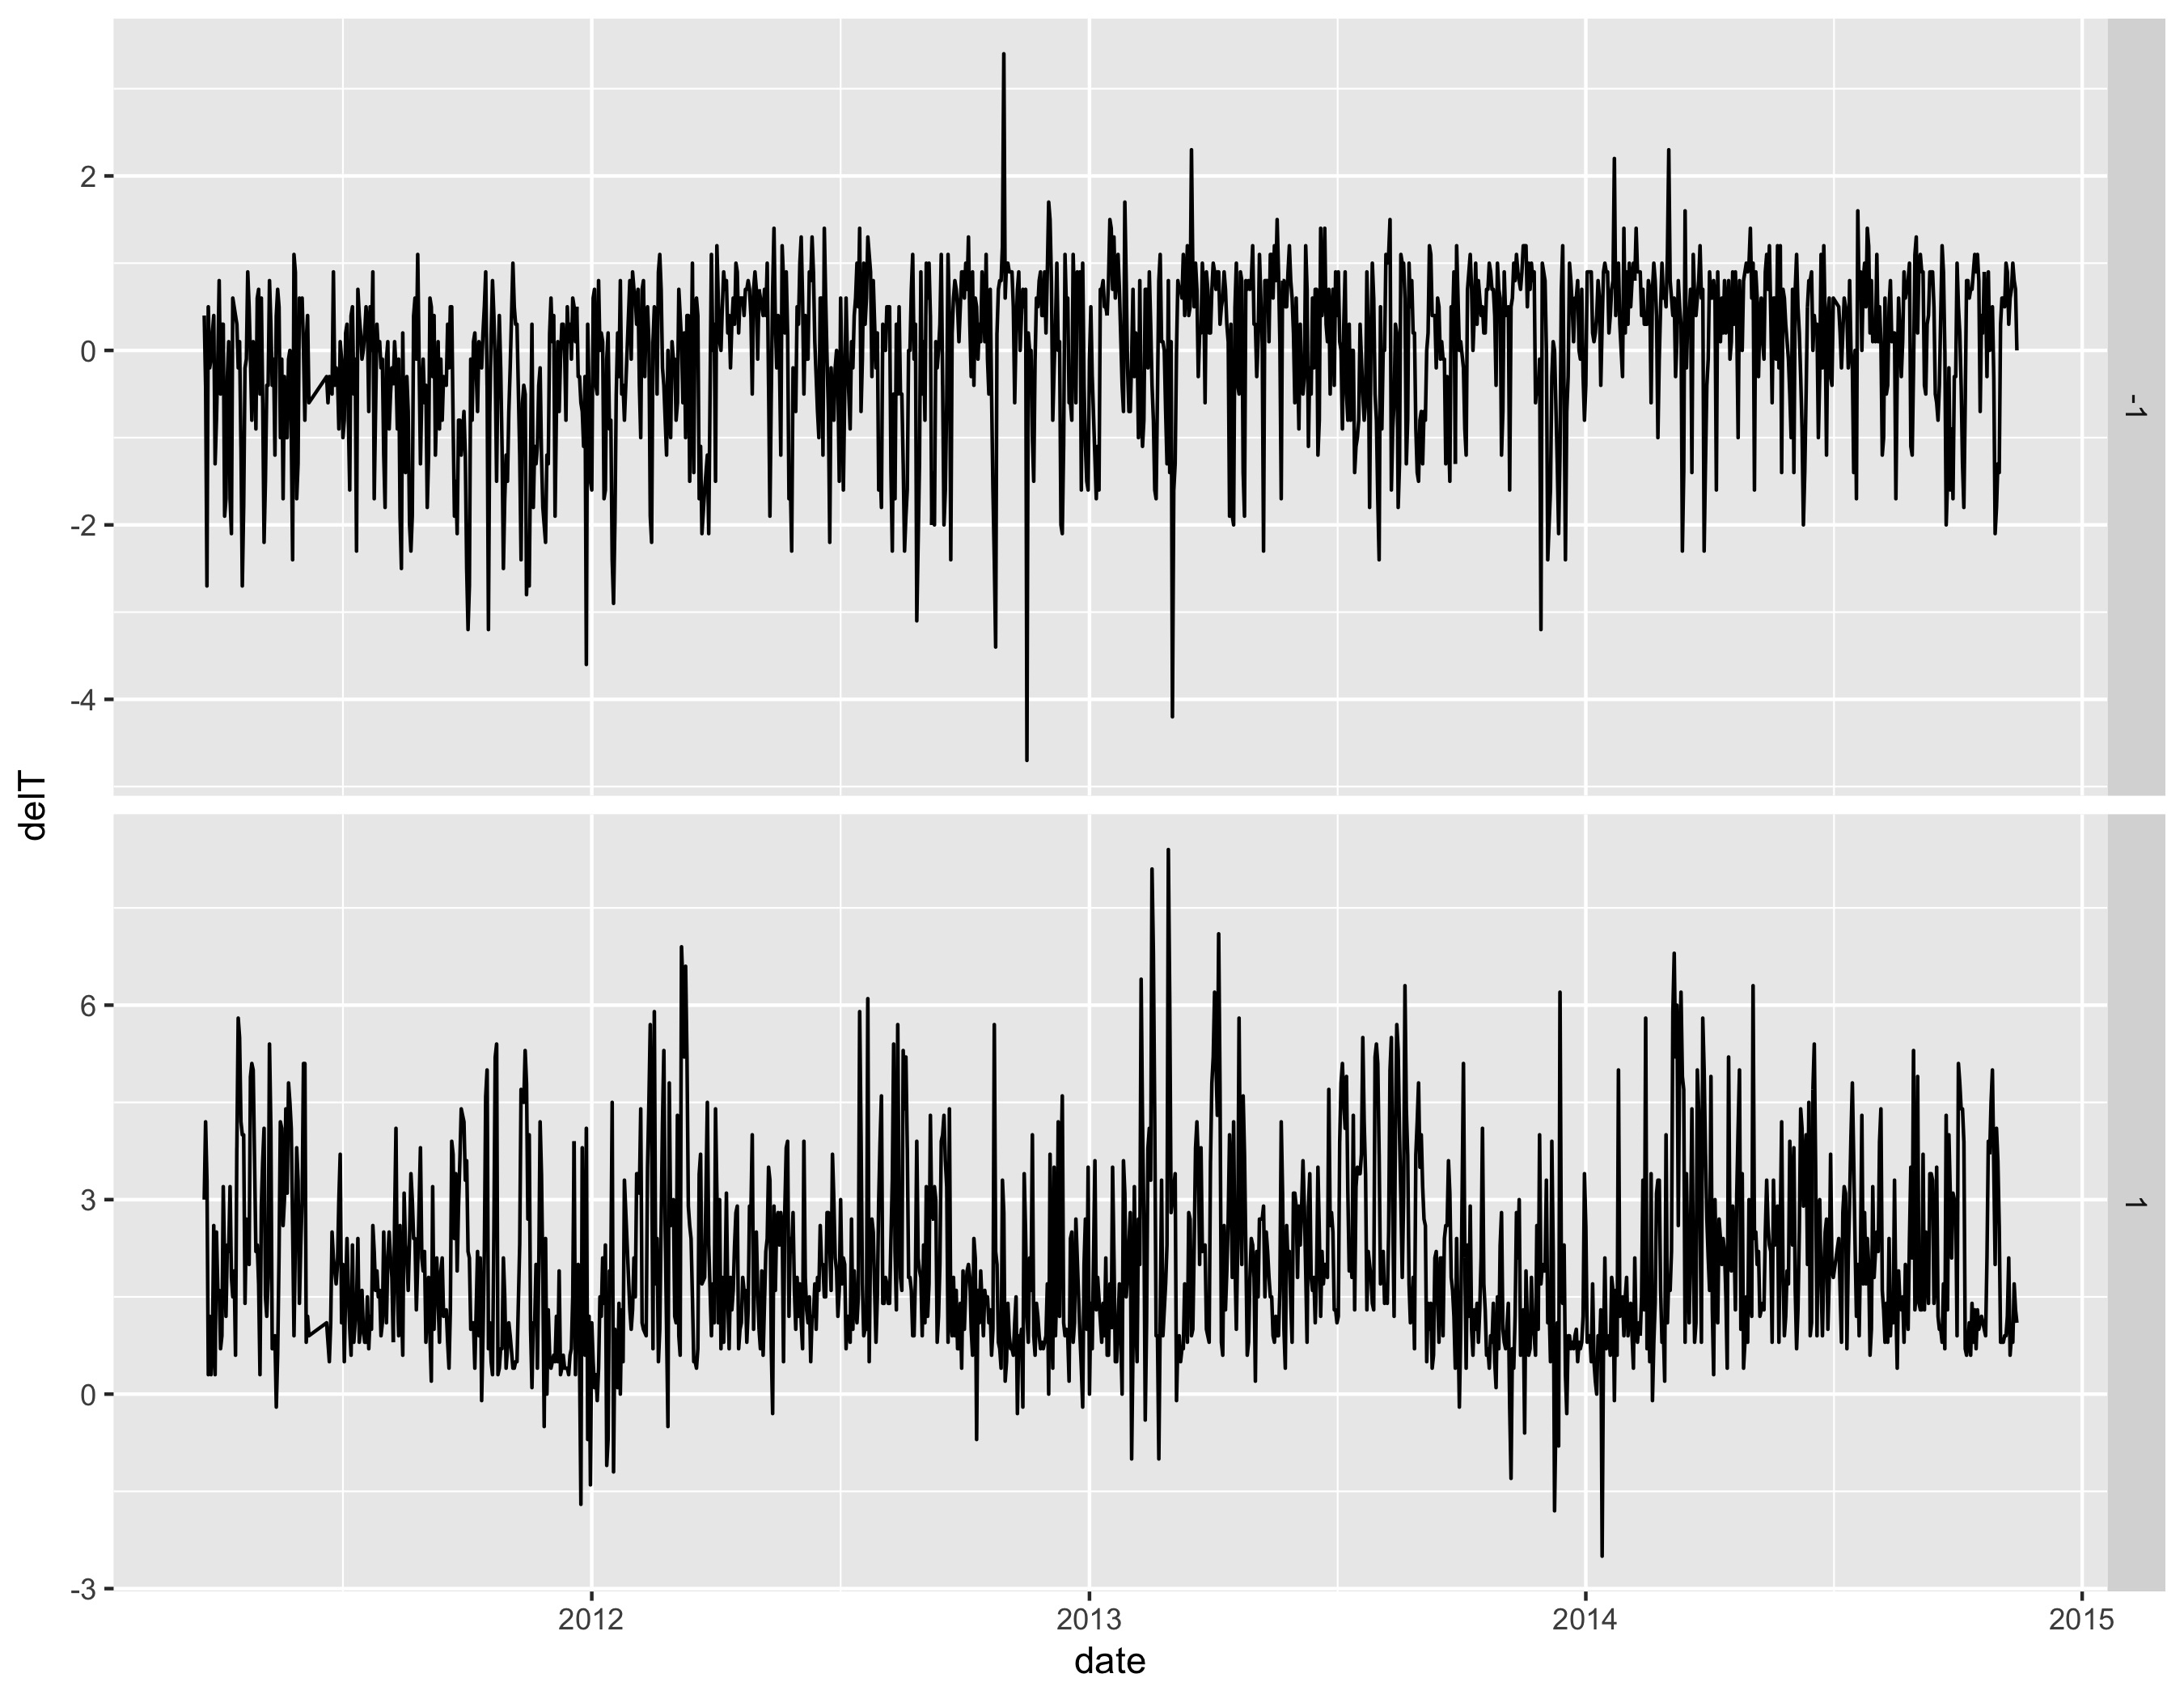

In [33]:
analysis |> filter(id_x == 8662L, id_y == 8661L) |> plot_diffs(conns$data)

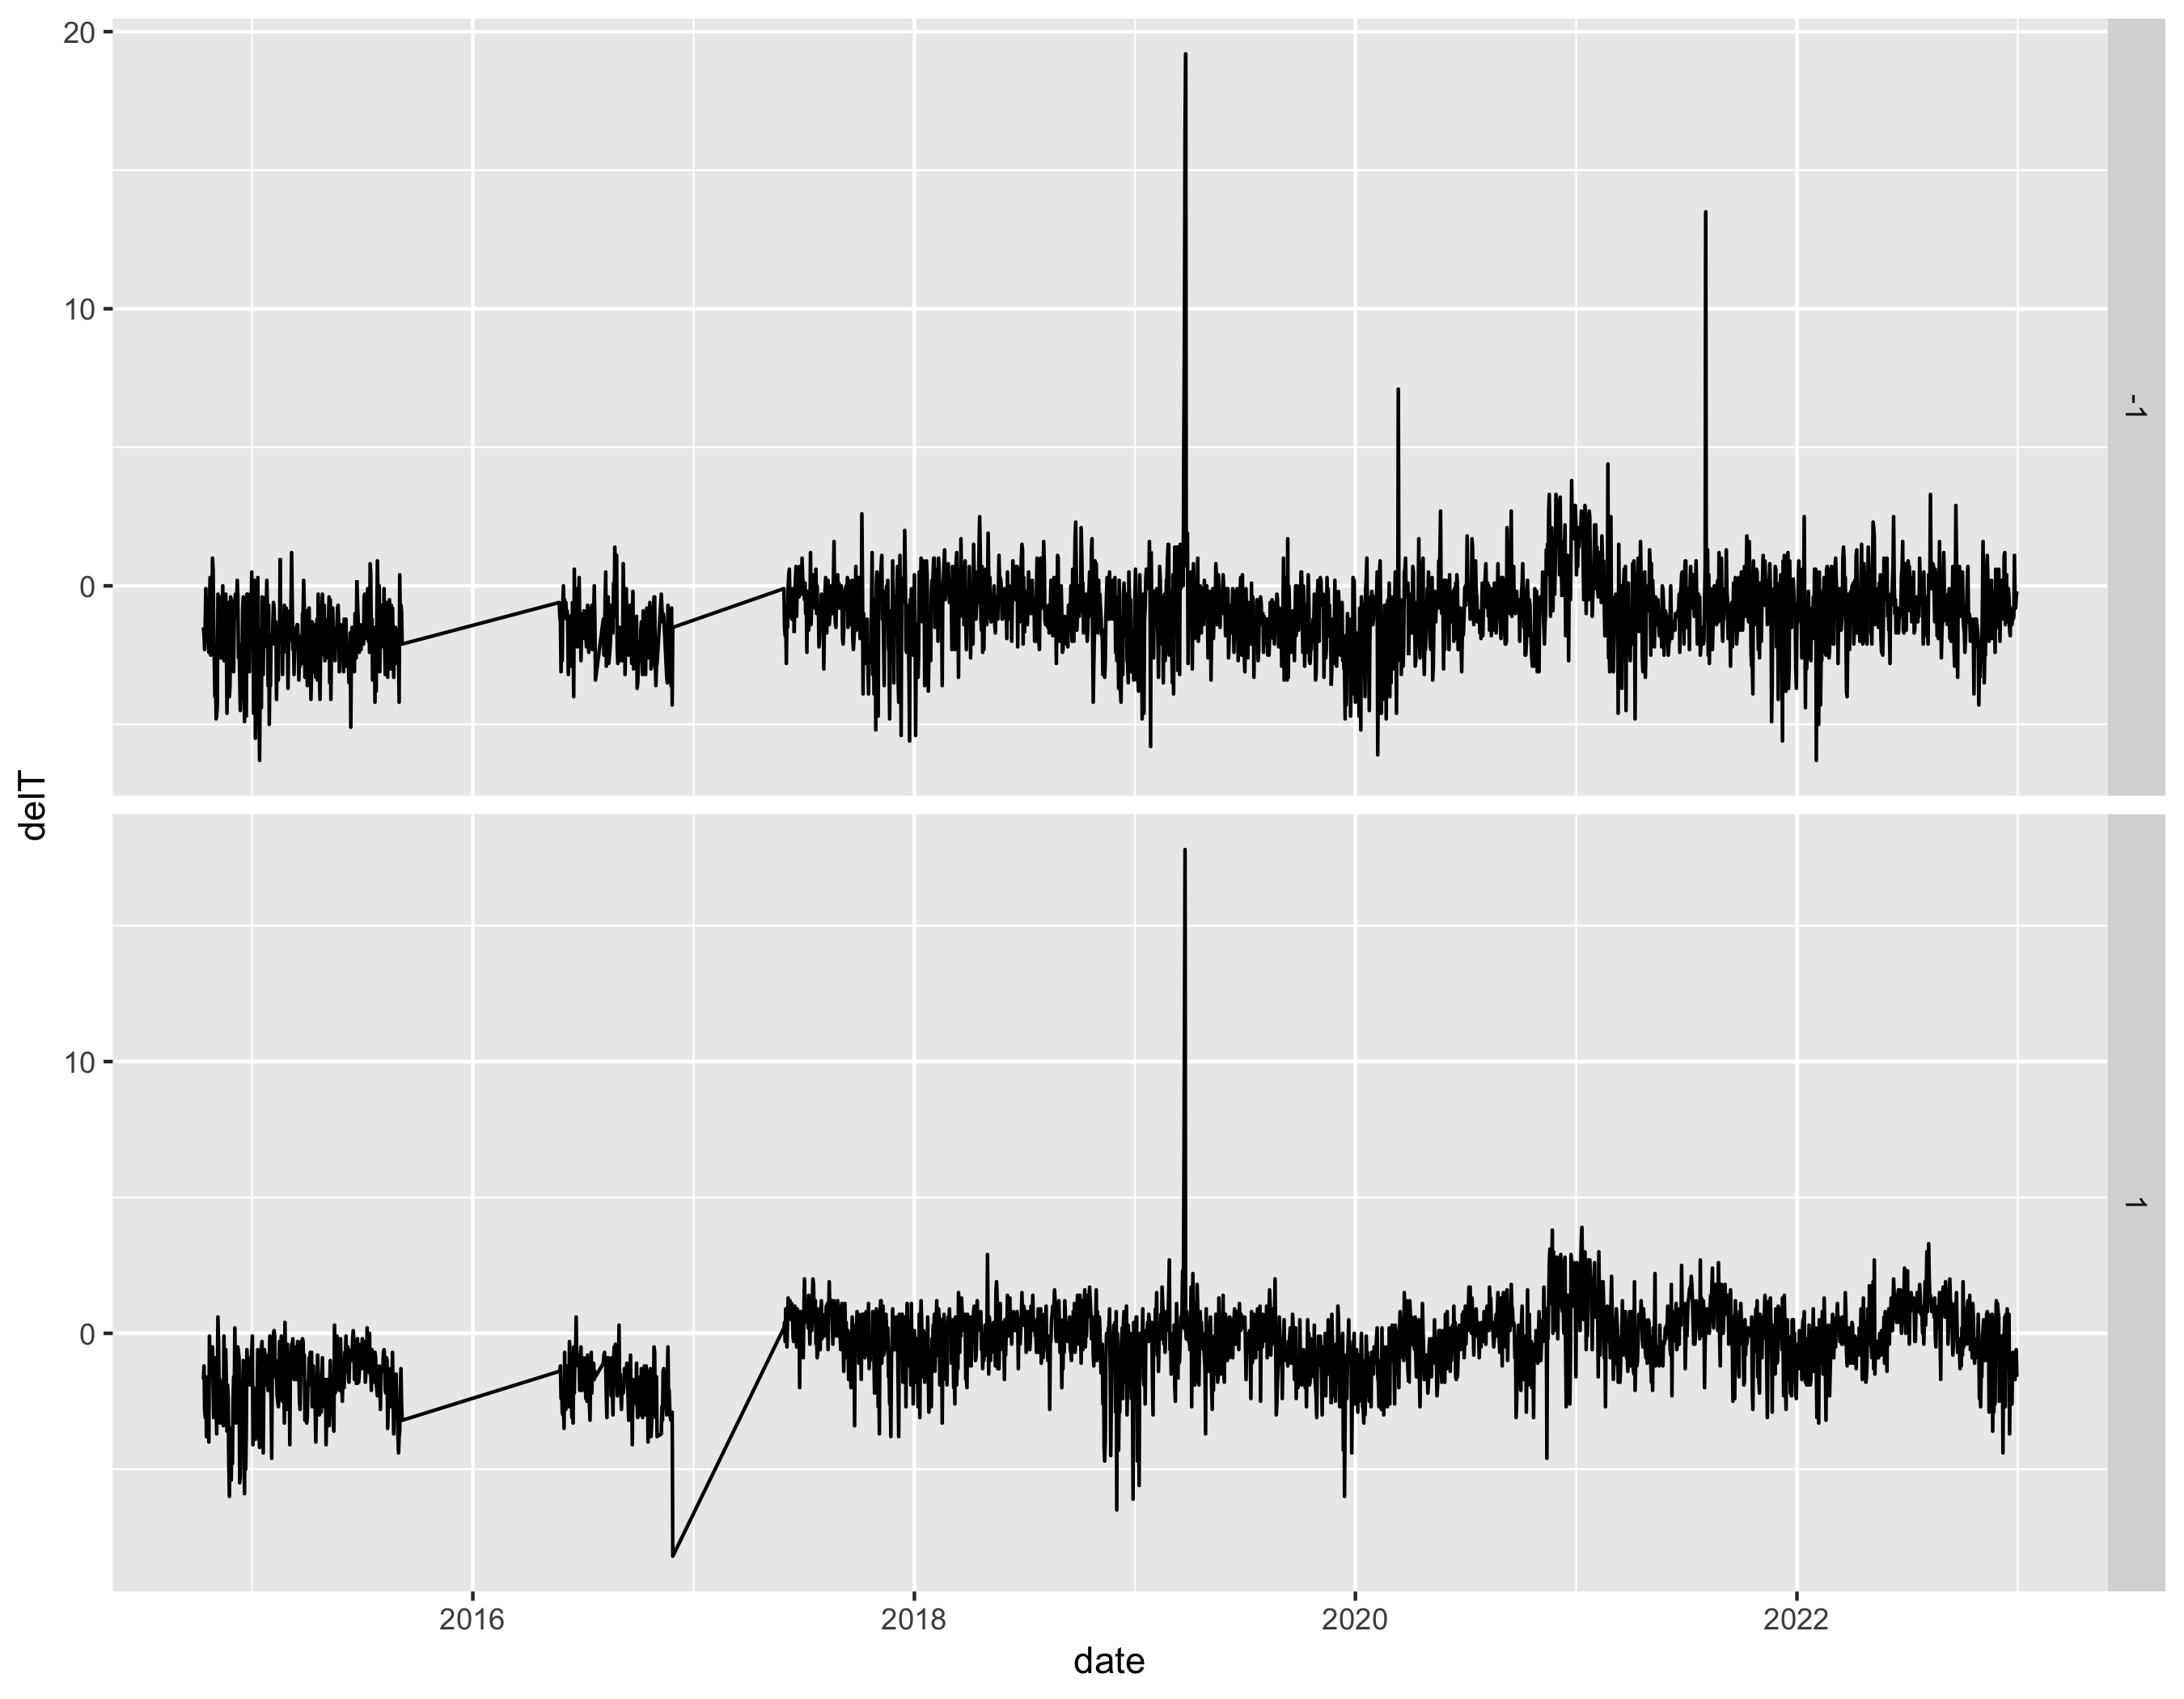

In [21]:
analysis |> filter(id_x == 3296L, id_y == 2948L) |> plot_diffs(conns$data)

In [36]:
source("notebooks/integrazioni_regionali/toscana/procedures/taggers.R")
tagged_analysis <- tag_analysis(analysis)

In [38]:
tagged_analysis |> filter(tag_mergeable)

id_x,id_y,variable,maeT,delT,sdT,valid_days_x,valid_days_y,valid_days_inters,valid_days_union,...,glo30m_elevation_y,glo30asec_elevation_y,delH,delZm,delZsec,norm_name_x,norm_name_y,strSym,tag_same_station,tag_mergeable
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
8191,5546,-1,9.970467e-02,-9.482182e-02,0.2417173906,7646,5636,5079,8203,...,1150.50000,1176.573120,-35.00,-53.900879,-23.540771,lago paduli,lago paduli,1.0000000,TRUE,TRUE
8288,7084,-1,8.672783e-02,-7.810398e-02,0.1898238986,3270,8401,3270,8401,...,15.88461,20.457294,16.00,0.000000,0.000000,lucca,lucca (orto botanico),0.8476190,TRUE,TRUE
6709,6708,-1,2.423237e-01,-1.936376e-01,0.2422503371,3566,801,723,3644,...,368.37796,312.629730,-71.00,-53.923889,-33.040314,tendola,tendola,1.0000000,TRUE,TRUE
7218,6640,1,0.000000e+00,0.000000e+00,0.0000000000,3014,459,459,3014,...,34.79363,21.046457,6.00,18.792933,0.000000,stabbia,stabbia,1.0000000,TRUE,TRUE
9042,7197,1,2.345867e-01,2.340681e-01,0.2822169080,3085,5477,3085,5477,...,17.60949,11.719541,7.63,8.169752,1.385560,san giovanni valle,s. giovanni alla vena valle,0.7666667,TRUE,TRUE
7875,5151,-1,1.189036e-01,-1.189036e-01,0.1791761665,3011,5604,529,8086,...,1.74059,3.912678,4.00,-5.618082,0.000000,coltano,coltano,1.0000000,TRUE,TRUE
8809,6219,-1,1.107071e-01,-7.797980e-02,0.3937003418,3014,4011,495,6530,...,32.91259,38.418362,41.00,0.000000,0.000000,ponte di monterufoli,ponte di monterufoli,1.0000000,TRUE,TRUE
7203,6401,-1,0.000000e+00,0.000000e+00,0.0000000000,3010,452,452,3010,...,10.64092,7.051543,0.00,7.203496,0.000000,s. rossore,s. rossore,1.0000000,TRUE,TRUE
6979,4743,1,0.000000e+00,0.000000e+00,0.0000000000,3360,807,807,3360,...,661.30536,775.492920,83.00,0.000000,0.000000,bosco di rossano,bosco di rossano,1.0000000,TRUE,TRUE


## Merging [TBD]
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [ ]:
qc_state <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
analysis_results <- perform_analysis(
    qc_state,
    qc_scia,
    dist_km = , # 10,
    first_date,
    last_date,
    str_to_lower(state),
)

rm(qc_state)
rm(qc_scia)
gc()


In [ ]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


In [ ]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1, match_selectors = NULL)
checkpoint_database(combination_results$database, dataset_id, "scia_merged")
save_match_list(combination_results$match_list, dataset_id, "scia_merged")


In [ ]:
stations <- open_metadata(c(dataset, "SCIA", "ISAC"), "raw", TRUE) |> filter_inside(state_boundaries)
state_data <- query_from_checkpoint(c(dataset, "SCIA", "ISAC"), "raw") |>
    semi_join.ddb(stations, join_by(dataset, station_id == id))

c(p, ymonthly_avail) %<-% ymonthly_availabilities(state_data)
p


In [ ]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, stations, state_boundaries)
p


In [ ]:
rm(stations, state_data, ymonthly_avail, climats, p)
gc()


### Merge interno

In [ ]:
scia_merged <- open_checkpoint(dataset_id, "scia_merged")
analysis_results <- perform_analysis_symmetric(
    scia_merged,
    dist_km = 6,
    first_date,
    last_date,
    file.path("vda", "internal.xlsx"),
    default_symmetric_filter,
    priority_table = NULL,
)

rm(scia_merged)
gc()


In [ ]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_internal, "unusable" = tag_unusable_internal))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


In [ ]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1.5, match_selectors = NULL)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")
rm(combination_results)
gc()


In [ ]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


In [ ]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [ ]:
print("Available series per variable:")
climats |>
    as_tibble() |>
    group_by(variable, station_id) |>
    summarise(usable = all(clim_available), .groups = "drop_last") |>
    filter(usable) |>
    tally()


In [ ]:
rm(ymonthly_avail)
rm(climats)
rm(combined_database)
gc()


In [ ]:
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(dataset_id, "merged")$data |>
    distinct(station_id, variable) |>
    compute() |>
    nrow()
